# Question 1 — Network Traffic Simulation using SimPy

In [37]:
# Q1: SimPy - 3 routers in a chain with simple processing delays
!pip -q install simpy

In [38]:
import simpy
import random
import statistics
import math
import numpy as np
import matplotlib.pyplot as plt

random.seed(42)

In [39]:
# Parameters
PACKET_RATE = 2.0                 # packets per simulated second (Poisson)
SIM_TIME = 50                     # total simulated seconds
PROC_TIMES = [0.02, 0.03, 0.04]   # per-router processing delay (s)
STORE_CAP = 10_000
SAMPLE_DT = 0.1                   # how often to sample queue lengths

In [40]:
# Simple packet
class Packet:
    _id = 0  # static counter shared by all packets, used to assign unique IDs

    def __init__(self, t0):
        Packet._id += 1           # increment global packet counter
        self.id = Packet._id      # assign this packet its own unique ID
        self.t0 = t0              # record the simulation time when the packet was created

# packet_source — continuously generates new packets and feeds them into the first router
def packet_source(env, out_store, rate, arrival_times):
    while True:
        # Wait for a random interval between packet arrivals (Poisson process)
        inter = random.expovariate(rate)
        yield env.timeout(inter)

        # Create a new packet at the current simulation time
        pkt = Packet(env.now)

        # Record its creation time for later statistics
        arrival_times.append(env.now)

        # Place the packet into the first router's input queue
        out_store.put(pkt)

# router — simulates one router in the chain
def router(env, name, in_store, out_store, proc_time, latencies, delivered_counter, depart_times):
    while True:
        # Wait until a packet becomes available in the input queue
        pkt = yield in_store.get()

        # Simulate time spent processing the packet
        yield env.timeout(proc_time)

        if out_store is None:
            # This is the last router — the packet has reached its destination
            total_latency = env.now - pkt.t0           # end-to-end delay
            latencies.append(total_latency)            # record latency
            delivered_counter[0] += 1                  # increment delivered packet counter
            depart_times.append(env.now)               # record time of delivery
        else:
            # Forward the packet to the next router’s input queue
            out_store.put(pkt)

# monitor_queues — collects queue length data over time
def monitor_queues(env, stores, sample_dt, t_samples, qlen_samples):
    """Record queue lengths every sample_dt."""
    while True:
        # Record current simulation time
        t_samples.append(env.now)

        # Record how many packets are waiting in each router’s queue
        qlen_samples.append([len(s.items) for s in stores])

        # Wait a bit before checking again
        yield env.timeout(sample_dt)

In [41]:
# Build environment and three queues (stores), one for each router
env = simpy.Environment()
s0, s1, s2 = (simpy.Store(env, capacity=STORE_CAP) for _ in range(3))

In [42]:
# Metrics
latencies = []             # end-to-end packet latencies
delivered_counter = [0]    # number of packets delivered (list used so it’s mutable)
arrival_times = []         # when packets were created
depart_times = []          # when packets were delivered
t_samples = []             # time samples for monitoring
qlen_samples = []          # queue lengths at each time sample

In [43]:
# Register all active simulation processes with the environment
env.process(packet_source(env, s0, PACKET_RATE, arrival_times))
env.process(router(env, "R1", s0, s1, PROC_TIMES[0], latencies, delivered_counter, depart_times))
env.process(router(env, "R2", s1, s2, PROC_TIMES[1], latencies, delivered_counter, depart_times))
env.process(router(env, "R3", s2, None, PROC_TIMES[2], latencies, delivered_counter, depart_times))
env.process(monitor_queues(env, [s0, s1, s2], SAMPLE_DT, t_samples, qlen_samples))

<Process(monitor_queues) object at 0x793599aa0950>

In [44]:
# Run
env.run(until=SIM_TIME)

In [45]:
# Results
throughput = delivered_counter[0] / SIM_TIME  # packets/sec delivered
avg_lat = statistics.mean(latencies) if latencies else float('nan')
p95_lat = statistics.quantiles(latencies, n=20)[18] if len(latencies) >= 20 else float('nan')

In [46]:
print(f"Sim time: {SIM_TIME}s")
print(f"Packets delivered: {delivered_counter[0]}")
print(f"Throughput: {throughput:.3f} pkts/s")
print(f"Average end-to-end latency: {avg_lat*1000:.2f} ms")
print(f"p95 latency: {p95_lat*1000:.2f} ms")

Sim time: 50s
Packets delivered: 101
Throughput: 2.020 pkts/s
Average end-to-end latency: 92.11 ms
p95 latency: 114.76 ms


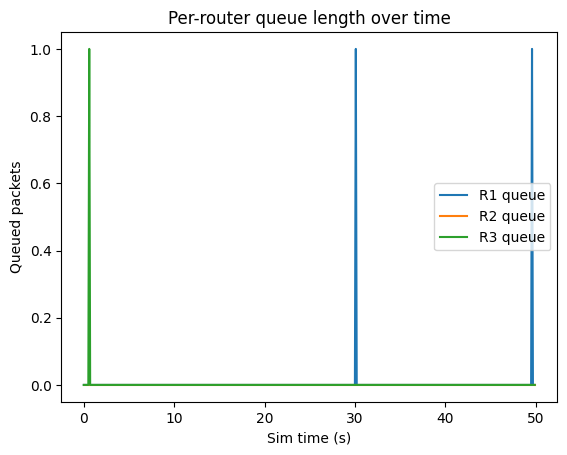

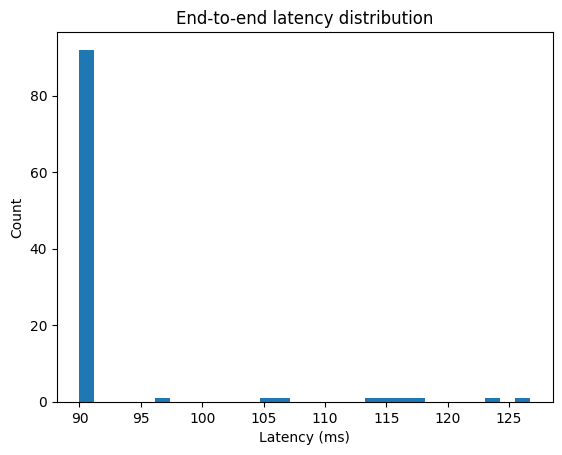

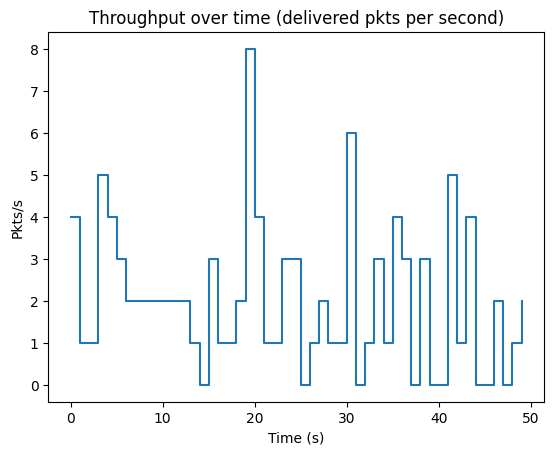

In [47]:
# ---------- Visualizations ----------

# Queue lengths over time
qlen_arr = np.array(qlen_samples) if qlen_samples else np.zeros((0,3))
plt.figure()
for i, label in enumerate(["R1 queue", "R2 queue", "R3 queue"]):
    plt.plot(t_samples, qlen_arr[:, i], label=label)
plt.title("Per-router queue length over time")
plt.xlabel("Sim time (s)")
plt.ylabel("Queued packets")
plt.legend()
plt.show()

# End-to-end latency distribution
plt.figure()
plt.hist(np.array(latencies)*1000, bins=30)
plt.title("End-to-end latency distribution")
plt.xlabel("Latency (ms)")
plt.ylabel("Count")
plt.show()

# Throughput over time (1-second bins)
bins = np.arange(0, SIM_TIME + 1, 1)
counts, _ = np.histogram(depart_times, bins=bins)
plt.figure()
plt.step(bins[:-1], counts, where='post')
plt.title("Throughput over time (delivered pkts per second)")
plt.xlabel("Time (s)")
plt.ylabel("Pkts/s")
plt.show()

# Question  2: Agent-Based Network Modeling using Mes

In [48]:
!pip -q install mesa networkx

In [49]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

# Core Mesa classes (works for both Mesa 2.x and 3.x)
from mesa import Agent, Model
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector

random.seed(42)
np.random.seed(42)

In [50]:
# Packet — minimal data structure representing a routed message
class Packet:
    def __init__(self, src, dst):
        """
        src: index of the source router (graph node id)
        dst: index of the destination router (graph node id)
        """
        self.src = src
        self.dst = dst

In [51]:
# RouterAgent — a router with a FIFO queue and simple rerouting
class RouterAgent(Agent):
    def __init__(self, node, model, capacity=50, reroute_threshold=10):
        """
        unique_id: router index (matches its node id in the graph)
        capacity: not enforced here; queue is "large" on purpose
        reroute_threshold: if chosen neighbor’s queue exceeds this,
                           pick the least loaded neighbor instead
        """
        super().__init__(model)
        self.node = node
        self.queue = deque()               # FIFO queue of Packet objects
        self.capacity = capacity           # retained for realism/documentation
        self.reroute_threshold = reroute_threshold
        self.processed = 0                 # number of forwarded packets

    def step(self):
        """
        Per tick, forward up to service_quota packets:
          1) If the packet’s destination is this router, deliver it.
          2) Otherwise choose the neighbor with the smallest queue.
          3) If that neighbor is "congested", switch to the least-loaded neighbor.
        """
        service_quota = 5  # simple per-tick service rate
        for _ in range(min(service_quota, len(self.queue))):
            pkt = self.queue.popleft()

            # Deliver locally if we are the destination
            if self.unique_id == pkt.dst:
                self.model.delivered += 1
                continue

            # Neighbor set from the graph
            neighbors = list(self.model.G.neighbors(self.node))
            if not neighbors:
                # Isolated router (shouldn't happen in our graph); drop silently
                continue

            # Best next hop: neighbor with the shortest queue
            best_next = min(neighbors, key=lambda n: len(self.model.router(n).queue))

            # Reroute if the best is too congested
            if len(self.model.router(best_next).queue) > self.reroute_threshold:
                alts = sorted(neighbors, key=lambda n: len(self.model.router(n).queue))
                best_next = alts[0]  # least loaded

            # Forward the packet
            self.model.router(best_next).enqueue(pkt)
            self.processed += 1

    def enqueue(self, pkt):
        """
        Add a packet to this router’s queue.
        We do not block or drop to keep the model simple/educational.
        """
        self.queue.append(pkt)

In [52]:
# UserAgent — periodically generates packets at an attached router
class UserAgent(Agent):
    def __init__(self, name, model, attach_router, send_prob=0.4):
        """
        unique_id: string like 'U0', 'U1', ...
        attach_router: the router (graph node id) this user injects traffic into
        send_prob: probability of generating a packet each step
        """
        super().__init__(model)
        self.name = name
        self.attach_router = attach_router
        self.send_prob = send_prob
        self.sent = 0

    def step(self):
        """
        With probability send_prob, generate a packet to a random destination router
        and enqueue it at the attached router.
        """
        if random.random() < self.send_prob:
            all_routers = list(self.model.routers.keys())
            dst = random.choice(all_routers)
            pkt = Packet(src=self.attach_router, dst=dst)
            self.model.router(self.attach_router).enqueue(pkt)
            self.sent += 1
            self.model.generated += 1

In [53]:
# NetworkABM — ties together the graph, routers, users, and metrics
class NetworkABM(Model):
    def __init__(self, n_routers=6, n_users=8, steps=200):
        """
        n_routers: number of routers (graph nodes)
        n_users: number of traffic-generating users
        steps: number of simulation ticks to run
        """
        # In Mesa 3.x, Model can take a seed parameter (optional). Not required here.
        super().__init__()
        self.steps_total = steps

        # --------------------------
        # Build the router graph G
        # --------------------------
        # Start with a cycle to ensure basic connectivity.
        self.G = nx.cycle_graph(n_routers)
        # Add a few chords for path diversity (alternate routes).
        self.G.add_edges_from([(0, 3), (1, 4), (2, 5)])
        # Tag nodes as routers (handy if you later mix node types)
        nx.set_node_attributes(self.G, {n: {"type": "router"} for n in self.G.nodes})

        # NetworkGrid keeps API consistency with Mesa’s network helpers
        self.grid = NetworkGrid(self.G)

        # -----------------------
        # Create router agents
        # -----------------------
        self.routers = {}
        for node in self.G.nodes:
            r = RouterAgent(model=self, node=node, capacity=50, reroute_threshold=10)
            self.routers[node] = r

        # -----------------------
        # Create user agents
        # -----------------------
        self.users = []
        for i in range(n_users):
            attach = random.randrange(n_routers)  # user’s "access" router
            u = UserAgent(name=f"U{i}", model=self, attach_router=attach, send_prob=0.35)
            self.users.append(u)

        # -----------------------
        # Global counters/metrics
        # -----------------------
        self.generated = 0   # cumulative packets generated by users
        self.delivered = 0   # cumulative packets delivered to destination

        # -----------------------
        # DataCollector — captures metrics each step for plotting later
        # -----------------------
        self.datacollector = DataCollector(
            model_reporters={
                "Generated":      lambda m: m.generated,  # cumulative generated
                "Delivered":      lambda m: m.delivered,  # cumulative delivered
                "AvgRouterQueue": lambda m: sum(len(r.queue) for r in m.routers.values()) / len(m.routers),
                "MaxRouterQueue": lambda m: max(len(r.queue) for r in m.routers.values()),
                "DeliveryRatio":  lambda m: (m.delivered / m.generated) if m.generated else 0.0
            }
        )

        # -----------------------
        # Internal agent list for activation (Mesa 3.x friendly)
        # We avoid deprecated/removed schedulers by shuffling this list
        # and calling step() on each agent manually.
        # -----------------------
        self._agents = list(self.routers.values()) + list(self.users)

    def router(self, node_id):
        """Helper to get a router by its graph node id."""
        return self.routers[node_id]

    def step(self):
        """
        One simulation tick:
          1) Collect metrics BEFORE actions (so plots include t=0)
          2) Randomize activation order (prevents bias)
          3) Let each agent act once (users may enqueue; routers forward/deliver)
        """
        self.datacollector.collect(self)
        random.shuffle(self._agents)
        for a in self._agents:
            a.step()

In [54]:
# Run the model
model = NetworkABM(n_routers=6, n_users=8, steps=200)
for _ in range(model.steps_total):
    model.step()

In [55]:
# Extract recorded time series of metrics
results = model.datacollector.get_model_vars_dataframe()

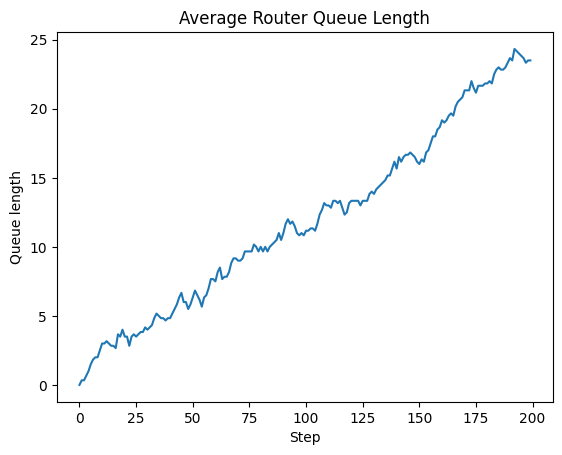

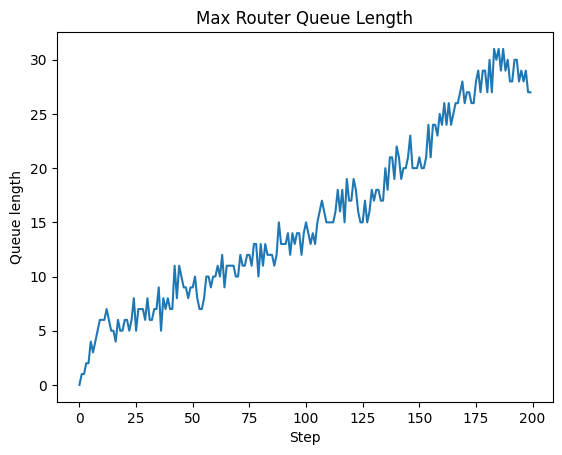

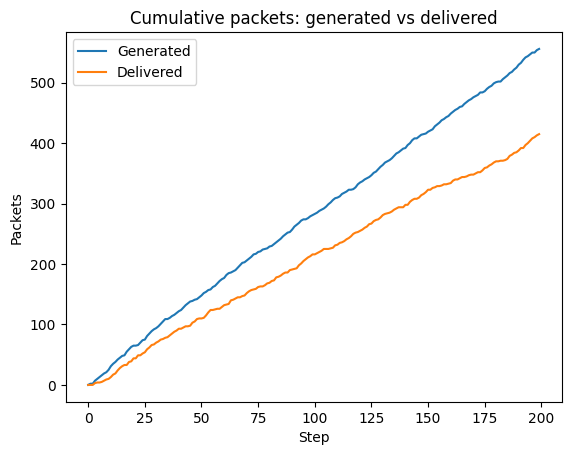

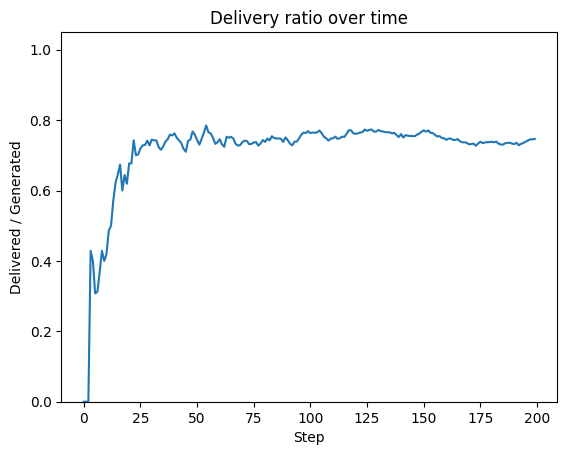

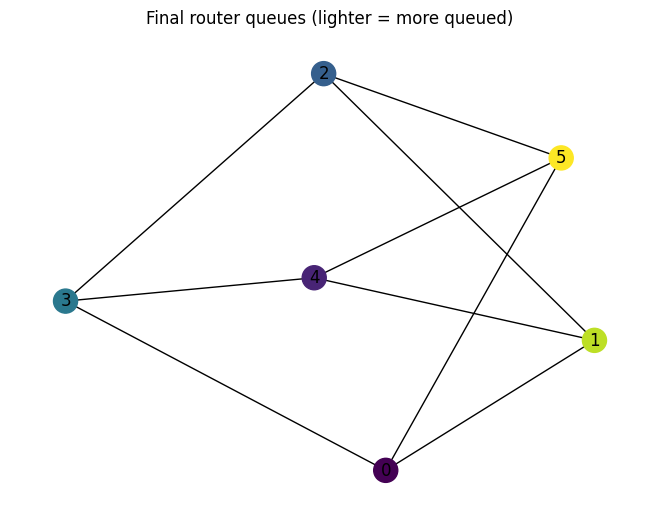

In [64]:
# 1) Average Router Queue Length over time — typical queue pressure network-wide
plt.figure()
results["AvgRouterQueue"].plot(title="Average Router Queue Length")
plt.xlabel("Step"); plt.ylabel("Queue length"); plt.show()

# 2) Max Router Queue Length over time — tracks the worst hotspot per step
plt.figure()
results["MaxRouterQueue"].plot(title="Max Router Queue Length")
plt.xlabel("Step"); plt.ylabel("Queue length"); plt.show()

# 3) Cumulative Generated vs Delivered — if Delivered keeps pace, network is coping
plt.figure()
results["Generated"].plot(label="Generated")
results["Delivered"].plot(label="Delivered")
plt.title("Cumulative packets: generated vs delivered")
plt.xlabel("Step"); plt.ylabel("Packets"); plt.legend(); plt.show()

# 4) Delivery Ratio over time — stabilization/recovery view of end-to-end success
plt.figure()
results["DeliveryRatio"].plot()
plt.title("Delivery ratio over time")
plt.xlabel("Step"); plt.ylabel("Delivered / Generated"); plt.ylim(0, 1.05); plt.show()

# 5) Final Network Queue "Heatmap" — color nodes by final queue size
final_queues = np.array([len(r.queue) for r in model.routers.values()])
norm_q = (final_queues - final_queues.min()) / (np.ptp(final_queues) + 1e-9)
pos = nx.spring_layout(model.G, seed=2)  # consistent layout
plt.figure()
nx.draw(model.G, pos=pos, with_labels=True, node_color=norm_q, cmap="viridis")
plt.title("Final router queues (lighter = more queued)")
plt.show()

# Question 3 Predictive Optimization using Machine Learning

In [1]:
!pip -q install scikit-learn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [3]:
# 1) Create a synthetic traffic time series for training/testing
rng = np.random.RandomState(42)

T = 400                           # total time steps
t = np.arange(T)                  # time index [0..T-1]

In [4]:
# Base level + two sine waves (different periods) + Gaussian noise
traffic = (
    50
    + 20*np.sin(2*np.pi*t/50)     # slow cycle
    + 10*np.sin(2*np.pi*t/17)     # faster cycle
    + rng.normal(0, 4, size=T)    # random noise
)
traffic = np.maximum(traffic, 1)  # avoid zero/negative traffic

In [5]:
# 2) Turn the time series into a supervised dataset (lag features)
LAG = 5
X, y = [], []
for i in range(LAG, T):
    X.append(traffic[i-LAG:i])  # last 5 points
    y.append(traffic[i])        # next point
X = np.array(X)
y = np.array(y)

In [6]:
# Train/test split (70% train, 30% test) — simple chronological split
split = int(0.7 * len(X))
X_train, y_train = X[:split], y[:split]
X_test,  y_test  = X[split:], y[split:]

In [7]:
# 3) Train a quick regression model (Random Forest)
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Evaluate next-step prediction error on the test set
pred = model.predict(X_test)
mae = mean_absolute_error(y_test, pred)
print(f"Test MAE (traffic units): {mae:.2f}")

Test MAE (traffic units): 4.59


In [8]:
# 4) Use predictions to optimize routing across two parallel paths
# Path characteristics (toy numbers chosen for illustration)
base1, base2 = 5.0, 7.0     # base latency (ms) for path 1 and 2
k1, k2 = 0.10, 0.06         # congestion sensitivity (ms per traffic unit)

def total_latency(trf, s):
    """Flow-weighted average latency for total traffic 'trf' and split 's' to Path 1."""
    l1 = base1 + k1*(s*trf)
    l2 = base2 + k2*((1-s)*trf)
    return s*l1 + (1-s)*l2

def optimal_split(trf):
    """
    Given total traffic trf, choose s in [0,1] that minimizes total_latency.
    We keep it super simple by scanning a small grid of candidate s values.
    (A closed-form exists for some linear forms, but grid search is clear.)
    """
    s_grid = np.linspace(0, 1, 51)
    vals = [total_latency(trf, s) for s in s_grid]
    return s_grid[int(np.argmin(vals))]

In [9]:
# Policy 1: Predictive policy — use predicted next-step traffic to choose s*
true_next = y_test
pred_next = pred
opt_splits = np.array([optimal_split(trf) for trf in pred_next])

In [10]:
# Policy 2: Static baseline
static_s = 0.5

In [11]:
# Compute per-step total latency for both policies using the *true* next traffic
opt_latency    = np.array([total_latency(trf, s) for trf, s in zip(true_next, opt_splits)])
static_latency = np.array([total_latency(trf, static_s) for trf in true_next])

In [12]:
# Aggregate comparison
improvement = (static_latency.mean() - opt_latency.mean()) / static_latency.mean() * 100
print(f"Avg latency (static 50/50): {static_latency.mean():.2f} ms")
print(f"Avg latency (predictive):  {opt_latency.mean():.2f} ms")
print(f"Relative improvement:      {improvement:.1f}%")

Avg latency (static 50/50): 7.92 ms
Avg latency (predictive):  7.91 ms
Relative improvement:      0.2%


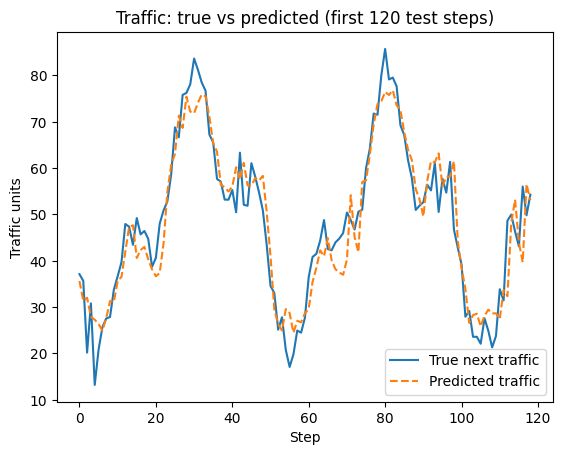

In [13]:
# Visualization 1: True vs Predicted Traffic (first 120 test steps)
# Purpose: check of model quality; close tracking means lower MAE.
plt.figure()
plt.plot(true_next[:120], label="True next traffic")
plt.plot(pred_next[:120], label="Predicted traffic", linestyle="--")
plt.title("Traffic: true vs predicted (first 120 test steps)")
plt.xlabel("Step"); plt.ylabel("Traffic units"); plt.legend(); plt.show()

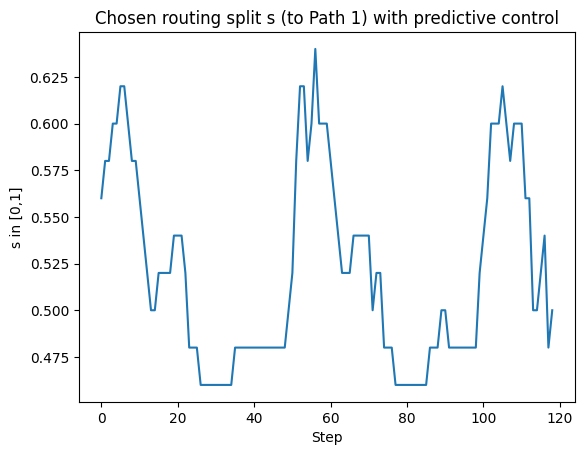

In [14]:
# Visualization 2: Chosen Routing Split s (to Path 1) over time
# Purpose: shows how the predictive controller reacts to changing load.
plt.figure()
plt.plot(opt_splits)
plt.title("Chosen routing split s (to Path 1) with predictive control")
plt.xlabel("Step"); plt.ylabel("s in [0,1]"); plt.show()

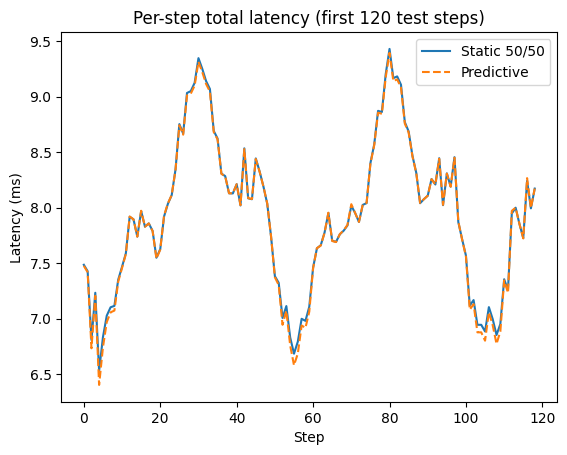

In [15]:
# Visualization 3: Per-step Total Latency (first 120 steps)
# Purpose: visual comparison of predictive vs static policy at each step.
plt.figure()
plt.plot(static_latency[:120], label="Static 50/50")
plt.plot(opt_latency[:120],  label="Predictive", linestyle="--")
plt.title("Per-step total latency (first 120 test steps)")
plt.xlabel("Step"); plt.ylabel("Latency (ms)"); plt.legend(); plt.show()

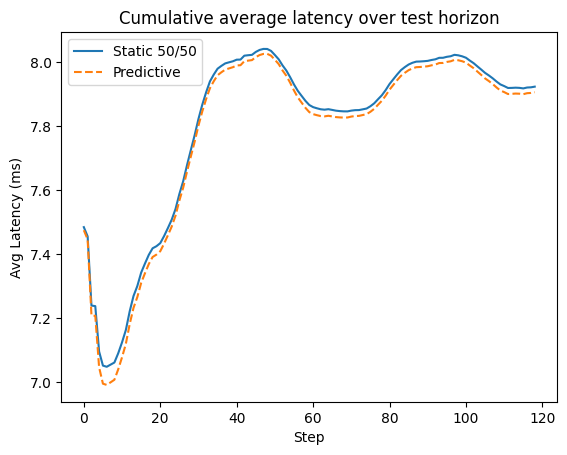

In [16]:
# Visualization 4: Cumulative Average Latency over Test Horizon
# Purpose: stability of the advantage — does predictive remain better on average?
cum_avg_static = np.cumsum(static_latency) / (np.arange(len(static_latency)) + 1)
cum_avg_opt    = np.cumsum(opt_latency)    / (np.arange(len(opt_latency)) + 1)
plt.figure()
plt.plot(cum_avg_static, label="Static 50/50")
plt.plot(cum_avg_opt,    label="Predictive", linestyle="--")
plt.title("Cumulative average latency over test horizon")
plt.xlabel("Step"); plt.ylabel("Avg Latency (ms)"); plt.legend(); plt.show()

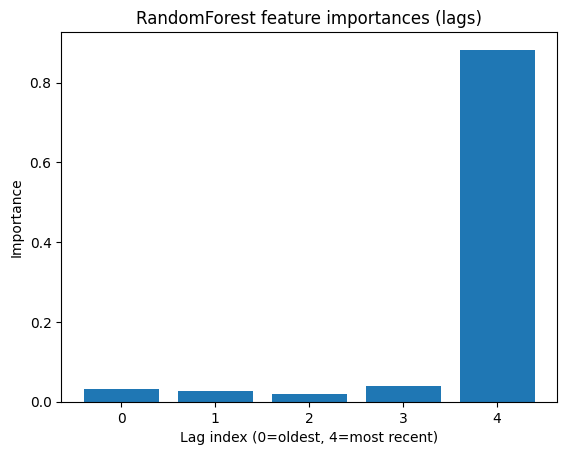

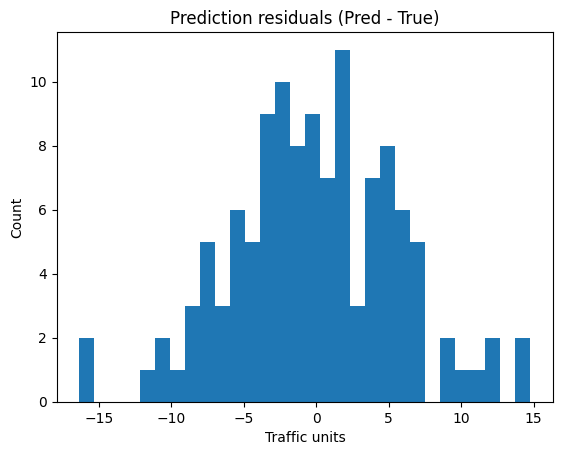

In [17]:
# Visualization 5: Model Diagnostics — Feature Importances & Residuals
# Purpose: (a) which lags matter most, (b) residual distribution for errors.
importances = model.feature_importances_
plt.figure()
plt.bar(range(LAG), importances)
plt.title("RandomForest feature importances (lags)")
plt.xlabel("Lag index (0=oldest, 4=most recent)"); plt.ylabel("Importance")
plt.show()

residuals = pred_next - true_next
plt.figure()
plt.hist(residuals, bins=30)
plt.title("Prediction residuals (Pred - True)")
plt.xlabel("Traffic units"); plt.ylabel("Count"); plt.show()